# WORK IN PROGRESS

# Context

---

Ran a script on AWS to scrape the top posts on Reddit's front page every hour from September to December 2018.

Here's a description of the columns in the dataset:

* extract_time -- The time the post's details were extracted
* headline -- The title of the post
* timestamp -- The time the post was submitted
* hyperlink -- The link the post leads to
* comments -- The number of comments the post had at the time of extraction
* submitter -- The user who submitted the post
* subreddit -- The subreddit the post was submitted to

## Setup
---

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import uuid
import wordcloud
from IPython.display import clear_output

In [2]:
# initiate plotly notebook mode
plotly.offline.init_notebook_mode(connected=True)

In [3]:
# configure matplotlib inline
%matplotlib inline
plt.rcParams["figure.figsize"] = 15,10

In [4]:
# import raw data
data = pd.read_csv("reddit_extract.csv")

In [5]:
# import prepared data
ordered = pd.read_csv("prepared_reddit_data.csv")

## Preparation for Analysis
---

In [6]:
# head
data.head(5)

,extract_time,headline,timestamp,hyperlink,comments,submitter,subreddit
0,2018-08-28 17:36:53.416007,IRS will allow employers to match their employ...,Tue Aug 28 13:49:52 2018 UTC,/r/personalfinance/comments/9az2w9/irs_will_al...,787 comments,broken_symmetry_,r/personalfinance
1,2018-08-28 17:36:53.416637,I Reached The Peak Of My Coolness In 1991,Tue Aug 28 12:50:49 2018 UTC,https://i.imgur.com/wFpbAsC.jpg,786 comments,TopS3cr3t,r/OldSchoolCool
2,2018-08-28 17:36:53.417336,MRW Creditors try to get a hold of me,Tue Aug 28 12:30:25 2018 UTC,https://i.imgur.com/0JGqbY2.gifv,257 comments,IronProdigyOfficial,r/reactiongifs
3,2018-08-28 17:36:53.417946,"""I would give him 10 stars, but since I can't,...",Tue Aug 28 13:57:14 2018 UTC,/r/mildlyinfuriating/comments/9az4w6/i_would_g...,188 comments,DrunkThrowsMcBrady,r/mildlyinfuriating
4,2018-08-28 17:36:53.418601,It works right?,Tue Aug 28 13:09:32 2018 UTC,/r/gaming/comments/9ayrto/it_works_right/,341 comments,radud3,r/gaming


In [7]:
# turn extract_time and timestamp into datetime
data.extract_time = pd.to_datetime(data.extract_time)
data.timestamp = pd.to_datetime(data.timestamp)

In [8]:
# check how many times the script ran
script_duration = data.extract_time.max() - data.extract_time.min()
print(f"The script ran {round(script_duration.total_seconds() / 3600)} times.")

The script ran 2976 times.


In [9]:
# check how many unique posts we have
unique_posts = data.drop_duplicates(["headline", "timestamp", "hyperlink", "submitter", "subreddit"])
print(f"There are {len(unique_posts)} unique posts in the dataset")

There are 21557 unique posts in the dataset


In [10]:
# check how many unique subreddits and users made it on to the list
print(f"There are {len(data.submitter.unique())} unique users in the dataset")
print(f"There are {len(data.subreddit.unique())} unique subreddits in the dataset")

There are 15961 unique users in the dataset
There are 675 unique subreddits in the dataset


In [11]:
# assign batch numbers based on extraction times. We can't use the unique extraction times 
# (minus the microseconds) as is since during some iterations the extraction of some of the 
# posts went beyond a second. So we need to normalize the extraction times first by rounding them up

def extract_time_normalizer(value):
    # return a rounded up hour
    return value.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
    
data = data.assign(batch_time = data.extract_time.apply(extract_time_normalizer))

# this should now match the number of times the script ran which is 2976
print(f"Number of unique extraction times after normalization: {len(data.batch_time.unique())}")

Number of unique extraction times after normalization: 2976


In [12]:
# now order the posts of each batch based on their extraction times

# to store the data with the ordering
ordered = pd.DataFrame()

for pos, batch in enumerate(data.batch_time.unique()):
    # extract batch and sort
    relevant = data[data.batch_time == batch].sort_values(by="extract_time")
    # assign order
    relevant = relevant.assign(order = range(len(relevant)))
    # append to the ordered store
    ordered = ordered.append(relevant)
    # track progress
    clear_output()
    print(pos)

2975


In [13]:
# assign an id to each of the unique posts and attach this to the dataset
unique_posts = unique_posts.assign(post_id = [uuid.uuid4().hex for i in range(len(unique_posts))])
unique_posts = unique_posts.drop(columns=["extract_time", "comments"])
ordered = ordered.merge(unique_posts, on=["headline", "timestamp", "hyperlink", "submitter", "subreddit"])

In [14]:
# backup the prepared data
ordered.to_csv("prepared_reddit_data.csv", index=False, encoding="utf-8")

## Analysis and Visualization
---

### Wordcloud of Headlines

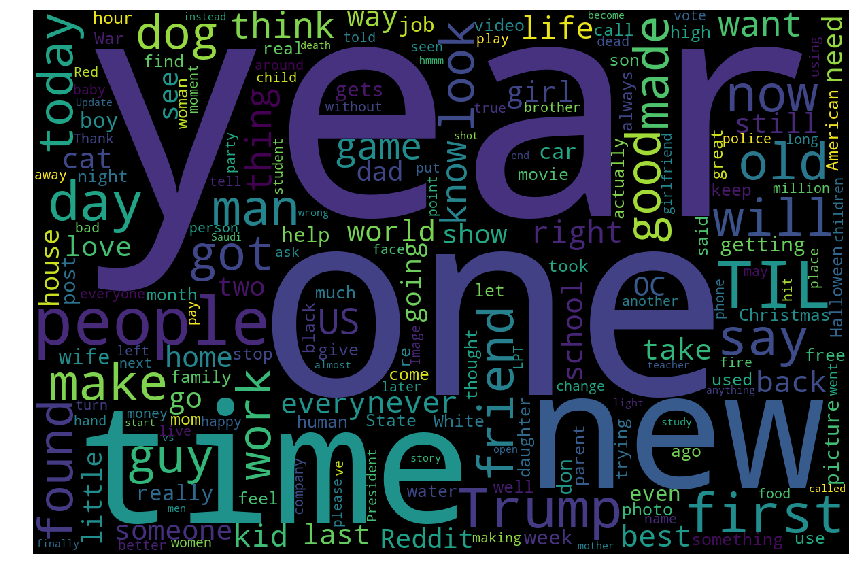

In [15]:
# take all of the headlines of the unique posts and turn them into a wordcloud
reddit_cloud = wordcloud.WordCloud(width=1200, height=800, prefer_horizontal=0.9, max_words=200,
                                   min_font_size=4, collocations=False, colormap="viridis",
                                   background_color="black")

reddit_cloud.generate_from_text(" ".join(ordered.drop_duplicates("post_id").headline.tolist()))

plt.imshow(reddit_cloud)
plt.axis("off")
plt.show()

### Top 10 Subreddits with the Most Posts (Unique) on the Front Page

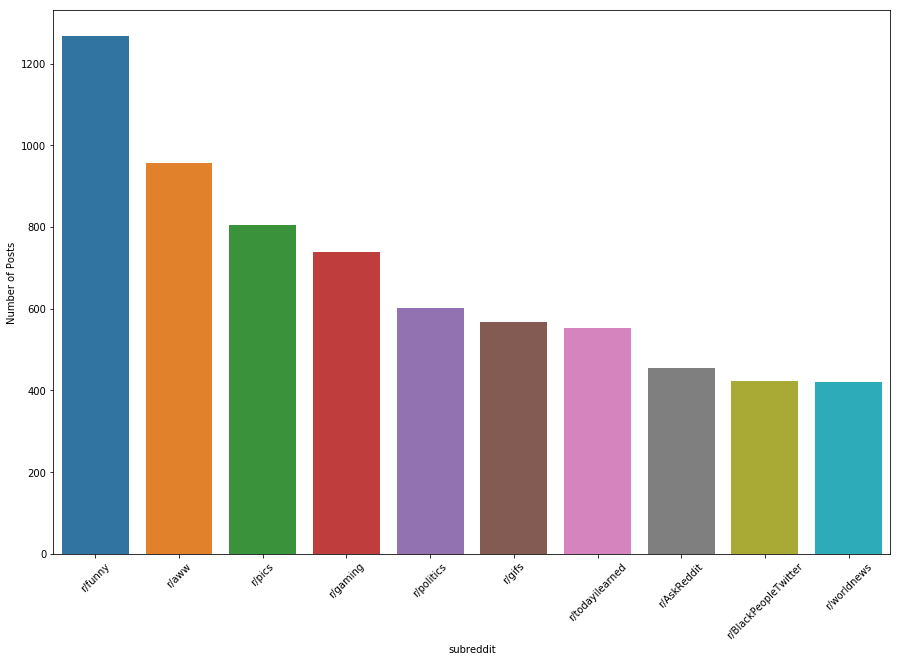

In [182]:
# interactive graph to show top subreddits by unique posts on the entire front page

# top 10 subreddits with the most posts (unique) across the entire front page
top_overall_subreddits = ordered.groupby("subreddit")["post_id"].nunique().sort_values(ascending=False).reset_index()

# visualize
vis = sns.barplot(
    data=top_overall_subreddits.iloc[:10, :],
    x="subreddit",
    y="post_id"
)

vis.set_ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.show()

### Top 10 Users with the Most Posts (Unique) on the Front Page

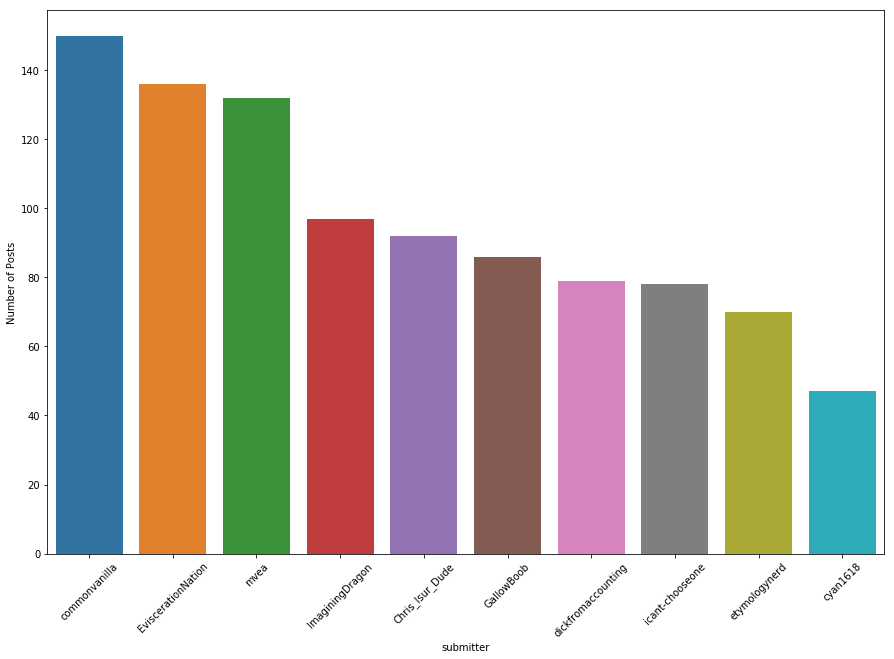

In [183]:
# graph to show top users by unique posts on the entire front page

# top 10 users with the most posts across the entire front page
top_overall_users = ordered.groupby("submitter")["post_id"].nunique().sort_values(ascending=False).reset_index()

# visualize
vis = sns.barplot(
    data=top_overall_users.iloc[:10, :],
    x="submitter",
    y="post_id"
)

vis.set_ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.show()

### Top 10 Posts that Spent the Most Time on the Front Page

In [20]:
# most time == most number of records in the dataset since the same post would've been
# captured repeatedly every hour

# get the top 10 unique posts with the most records in the dataset
top10_posts = ordered.post_id.value_counts().iloc[:10].index.tolist()

# show relevant detailed information of top 10 posts (including the last captured comment count)
top10_posts_detailed = ordered[ordered.post_id.isin(
    top10_posts)].sort_values("batch_time").drop_duplicates("post_id", keep="last")

# adjust pandas column width
pd.set_option('display.max_colwidth', -1)

# display as table because sometimes it's just easier to read
top10_posts_detailed[["timestamp", "headline", "subreddit", "comments"]].reset_index(drop=True)

,timestamp,headline,subreddit,comments
0,2018-10-19 16:25:15+00:00,What's up with people sayibg to not watch or stop watching CinemaSins?,r/OutOfTheLoop,1255 comments
1,2018-11-05 12:02:11+00:00,AITA for trolling an elderly person who kept calling the wrong number?,r/AmItheAsshole,716 comments
2,2018-11-06 12:46:41+00:00,I. DID. NOT. ACCEPT. THE. JOB. Now please let me enjoy my holiday,r/IDontWorkHereLady,714 comments
3,2018-11-06 13:33:46+00:00,It’s Election Day 2018 and We’ve Compiled Some Resources to Help You Vote,r/announcements,5484 comments
4,2018-11-06 06:04:27+00:00,Red Dead Redemption 2 allows you to kill KKK members without penalty. Some on /r/gaming wonder if Rockstar's gone too far with the murdering,r/SubredditDrama,2522 comments
5,2018-11-06 12:45:02+00:00,Can I get in trouble for giving my underage wife alcohol?,r/legaladvice,84 comments
6,2018-11-13 14:15:33+00:00,In ww1 when the soldiers on the battlefields had to stop fighting mid-battle because the war ended did they just throw down there weapons? Or did they awkwardly just walk back to their separate camps?,r/history,1048 comments
7,2018-12-04 06:05:12+00:00,Update on LAOP who was violently raped 6 yrs ago and found out her assailant was trying to become an officer. Turns out the man isn't going to be an officer but LAOP still went through with reporting it.,r/bestoflegaladvice,247 comments
8,2018-12-17 13:16:39+00:00,MRW I spend most of my days doing my incompetent boss's job and then I find out his Christmas bonus was larger than my my yearly income,r/reactiongifs,1724 comments
9,2018-12-27 14:24:06+00:00,Macaulay Culkin to legally change his middle name to Macaulay Culkin,r/nottheonion,2469 comments


### Time (Hours) a Post Spends in Each Position

In [21]:
# re-adjust pandas column width
pd.set_option('display.max_colwidth', 50)

In [22]:
# this would involve calculating the number of records for each position for each unique post
pos_hours = ordered.pivot_table(
    values="extract_time",
    index=["post_id", "order"],
    aggfunc="count"
).reset_index().sort_values("extract_time", ascending=False).rename(columns={"extract_time": "hours_in_pos"})

# check if the total of hours in pos matches the total number of records in the dataset
pos_hours.hours_in_pos.sum() == len(ordered)

True

In [23]:
# assign the subreddit to pos_hours
pos_hours = pos_hours.merge(ordered[["post_id", "subreddit"]].drop_duplicates(), how="inner", on="post_id")

# remove all posts with only 1 record (observed to be only in one position for one hour)
post_counts = pos_hours.post_id.value_counts().reset_index().rename(
    columns={"post_id": "num_of_posts", "index": "post_id"})
to_remove = post_counts[post_counts.num_of_posts == 1].post_id.tolist()
pos_hours = pos_hours[~pos_hours.post_id.isin(to_remove)]

In [187]:
# calculate average number of hours posts spend in each position
hours_spent = pos_hours.groupby("order")["hours_in_pos"].mean().reset_index()
hours_spent = hours_spent.rename(columns={"hours_in_pos": "average_hours"})

# append to this the maximum number of hours a post spent in each position
hours_spent = hours_spent.merge(
    pos_hours.groupby("order")["hours_in_pos"].max().reset_index(), 
    how="inner", 
    on="order")
hours_spent = hours_spent.rename(columns={"hours_in_pos": "max_hours"})

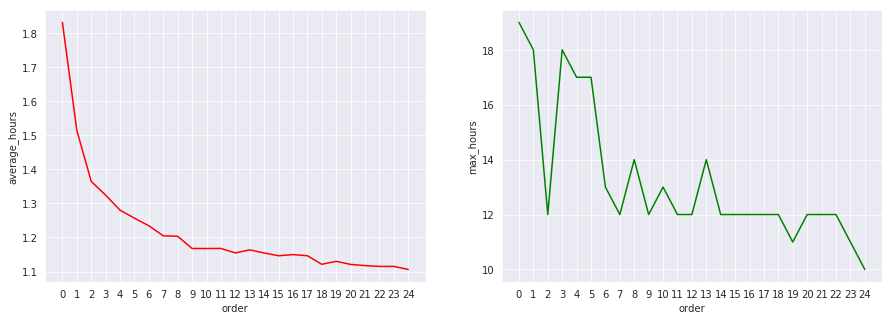

In [221]:
# visualize
sns.set_style("darkgrid")

f, ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.ravel()

vis1 = sns.lineplot(
    data=hours_spent,
    x="order",
    y="average_hours",
    ax=ax[0],
    color="red"
)



vis2 = sns.lineplot(
    data=hours_spent,
    x="order",
    y="max_hours",
    ax=ax[1],
    color="green"
)

vis1.set(xticks=range(0,25))
vis2.set(xticks=range(0,25))

plt.show()

In [188]:
# calculate average number of hours posts spend in each position for each subreddit
hours_spent_subreddit = pos_hours.groupby(["order", "subreddit"])["hours_in_pos"].mean().reset_index()
hours_spent_subreddit = hours_spent_subreddit.rename(columns={"hours_in_pos": "average_hours"})

# append to this the maximum number of hours a post spent in each position for each subreddit
hours_spent_subreddit = hours_spent_subreddit.merge(
    pos_hours.groupby(["order", "subreddit"])["hours_in_pos"].max().reset_index(), 
    how="inner", 
    on=["order", "subreddit"])
hours_spent_subreddit = hours_spent_subreddit.rename(columns={"hours_in_pos": "max_hours"})

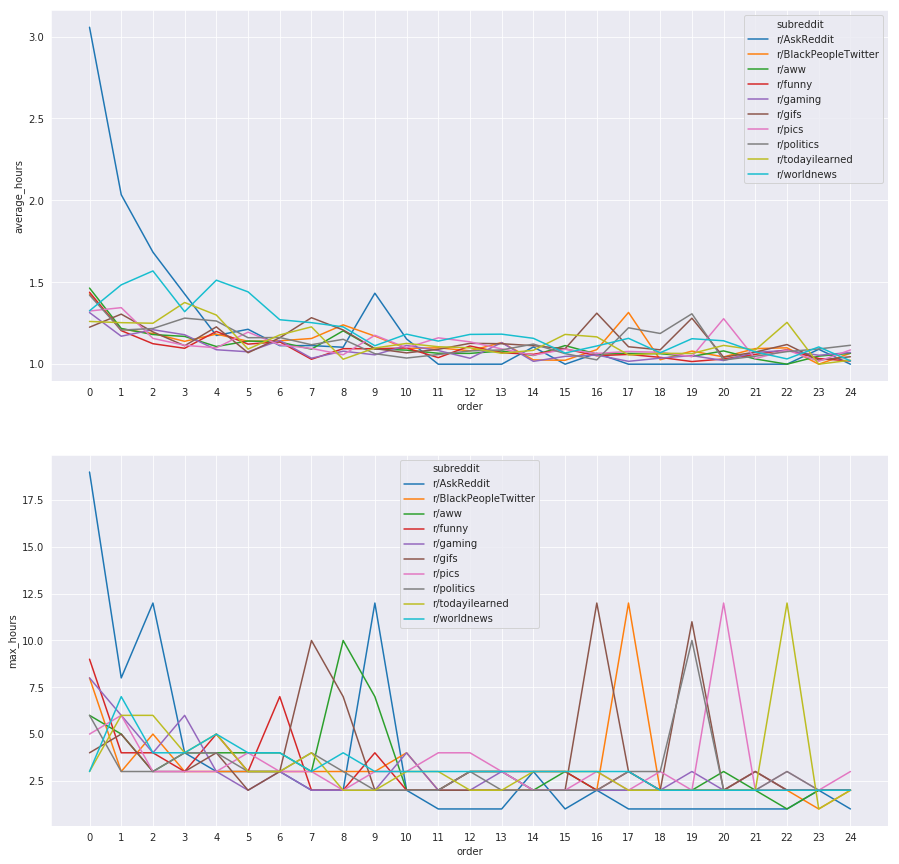

In [241]:
# for the top 10 subreddis (by num of posts on the front page, see above) visualize the average and max hours
top_subreddits = top_overall_subreddits.iloc[:10, :].subreddit.tolist()

f, ax = plt.subplots(2,1, figsize=(15,15))
ax = ax.ravel()

vis1 = sns.lineplot(
    data=hours_spent_subreddit[hours_spent_subreddit.subreddit.isin(top_subreddits)],
    x="order",
    y="average_hours",
    hue="subreddit",
    ax=ax[0]
)

vis2 = sns.lineplot(
    data=hours_spent_subreddit[hours_spent_subreddit.subreddit.isin(top_subreddits)],
    x="order",
    y="max_hours",
    hue="subreddit",
    ax=ax[1]
)

vis1.set(xticks=range(0,25))
vis2.set(xticks=range(0,25))

plt.show()

### Time (Hours) Taken to Reach Front Page

In [ ]:
# to-do

### Best Time to Post to Reach the Front Page

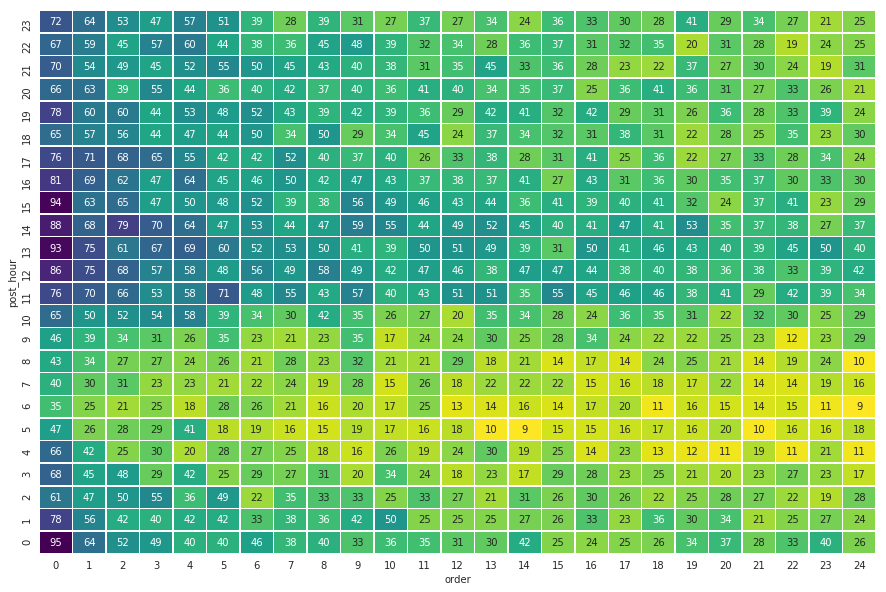

In [207]:
# assign hour column
ordered = ordered.assign(post_hour = ordered.timestamp.dt.hour)

# get the highest position each of the unique posts reached
highest_pos = ordered.groupby(["post_id", "post_hour"])["order"].min().reset_index()

# pivot for heatmap
by_hour_and_order = highest_pos.pivot_table(
    index="post_hour",
    columns="order",
    values="post_id",
    aggfunc="count"
)

# create heatmap using this data
vis = sns.heatmap(by_hour_and_order, annot=True, fmt="d", linewidths=0.5, cbar=False, cmap="viridis_r")
vis.invert_yaxis()

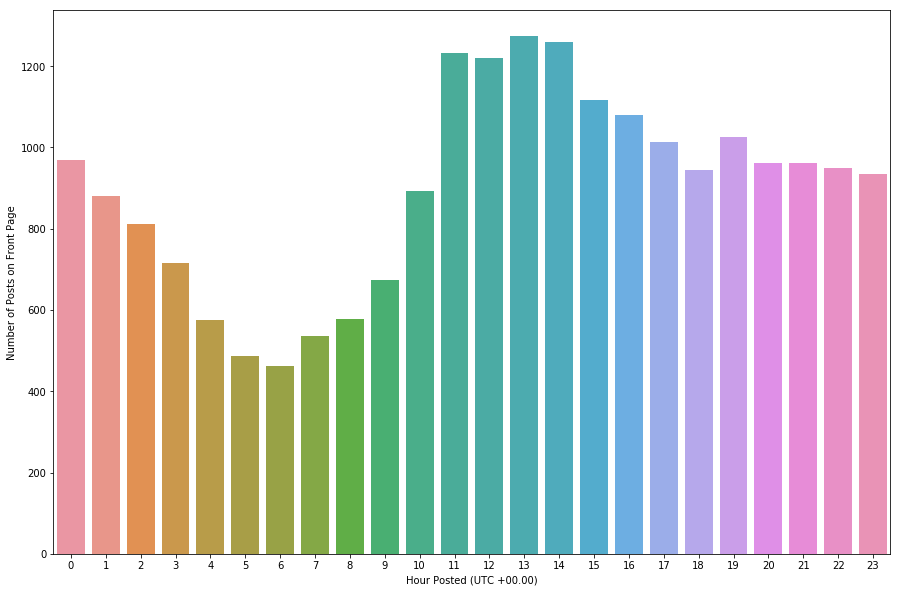

In [150]:
# what time were most posts that ended up on the front page posted at?
vis = sns.barplot(
    data=highest_pos["post_hour"].value_counts().reset_index().sort_values("index"),
    x="index",
    y="post_hour"
)

vis.set_xlabel("Hour Posted (UTC +00.00)")
vis.set_ylabel("Number of Posts on Front Page")
plt.show()

In [ ]:
# to be continued